![](https://miro.medium.com/max/691/0*xXUYOs5MWWenxoNz)

In [1]:
# необходимые импорты
import numpy as np
import os
import random
import torch
import torchvision.datasets as dataset
import torchvision.transforms as transforms

import monai
from monai.transforms import (
    EnsureChannelFirst,
    Resize,
    Compose,
    LoadImage,
    NormalizeIntensity,
    RandRotate,
    RandZoom,
    ToTensor,
)

from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [3]:
# определим функцию, которая будет вычислять точность модели на итерации
def calculate_accuracy(y_pred, y):

    # находим количество верных совпадений лейбла и выходного класса по каждому примеру в батче
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()

    # посчитаем точность, которая равна отношению количества верных совпадений к общему числу примеров в батче
    acc = correct.float() / y.shape[0]
    return acc

In [4]:
# функция, отвечающая за обучение сети на одной эпохе
def train(model, dataloader, optimizer, loss_function, device):
    # определим значения точности и потерь на старте эпохи
    epoch_acc = 0
    epoch_loss = 0

    # переведем модель в режим тренировки
    model.train()

    # для каждого батча в даталоадере
    for (images, labels) in dataloader:

        # отправляем изображения и метки на устройство
        images = images.to(device)
        labels = labels.to(device)

        # обнуляем градиенты
        optimizer.zero_grad()

        # вычислим выходы сети на данном батче
        predicts = model(images)

        # вычислим величину потерь на данном батче
        loss    = loss_function(predicts, labels)

        # вычислим точность на данном батче
        acc     = calculate_accuracy(predicts, labels)

        # вычислим значения градиентов на батче
        loss.backward()

        # корректируем веса
        optimizer.step()

        # прибавим значения потерь и точности на батче 
        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    # возвращаем величину потерь и точность на эпохе
    return epoch_loss / len(dataloader),  epoch_acc / len(dataloader)


In [5]:
# функция, отвечающая за проверку модели на одной эпохе
def evaluate(model, dataloader, loss_function, device):
    
    # определим начальные величины потерь и точности
    epoch_acc = 0
    epoch_loss = 0

    # переведем модель в режим валидации
    model.eval()

    # указываем, что градиенты вычислять не нужно
    with torch.no_grad():
      
        # для каждого батча в даталоадере
        for images, labels in dataloader:

            # переносим изображения и лейблы на устройство
            images = images.to(device)
            labels = labels.to(device)

            # вычислим выходы сети на батче
            predicts = model(images)

            # вычислим величину потерь на батче
            loss = loss_function(predicts, labels)

            # вычислим точность на батче
            acc  = calculate_accuracy(predicts, labels)


            # прибавим значения потерь и точности на батче к общему
            epoch_loss += loss.item()
            epoch_acc  += acc.item()

      
    # возвращаем величину потерь и точность на эпохе
    return epoch_loss / len(dataloader),  epoch_acc / len(dataloader)

       
        


In [6]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [7]:
# определим устройство, на котором будет идти обучение
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cuda')

In [ ]:
# определим объект трансформации изображений
# transform = transforms.Compose([
#       transforms.Resize((512, 512)),
#       transforms.ToTensor(),
#       transforms.RandomVerticalFlip(),
#       transforms.RandomHorizontalFlip()
# ])

aug_transforms = Compose([
      LoadImage(image_only=True),
      EnsureChannelFirst(),
      # LambdaD(keys="image", func=lambda x: x[0, :, :].unsqueeze(0) if x.ndim==3 else x),
      Resize(spatial_size=(512, 512)),
      NormalizeIntensity(),
      RandRotate(mode="bilinear", range_x=0.26, prob=0.5),
      RandZoom(mode="bilinear"),
      ToTensor(),
])

no_aug_transforms = Compose([
      LoadImage(),
      EnsureChannelFirst(),
      # LambdaD(keys="image", func=lambda x: x[0, :, :].unsqueeze(0) if x.ndim==3 else x),
      Resize(spatial_size=(512, 512)),
      NormalizeIntensity(),
      ToTensor(),
])

In [9]:
def get_images_list_recursive(path_to_subset: str) -> list[dict[str, int]]:
    images_list = []
    for root, dirs, files in os.walk(path_to_subset):
        for file in files:
            abs_path_to_image = os.path.abspath(os.path.join(root, file))
            class_of_image = 0 if os.path.split(os.path.dirname(abs_path_to_image))[-1] == "Glaucoma_Negative" else 1
            images_list.append({"image": abs_path_to_image, "class": class_of_image})
    return images_list

class GlaucomaDataset(monai.data.Dataset):
    def __init__(self, path_to_subset, transforms):
        self.images_list = get_images_list_recursive(path_to_subset)
        self.transforms = transforms
        self.classes = set([item["class"] for item in self.images_list])
        
    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, index):
        return self.transforms(self.images_list[index]["image"]), self.images_list[index]["class"]

In [10]:
train_path = r"E:\Datasets\Glaucoma_detection\Fundus_Train_Val_Data\Fundus_Scanes_Sorted\Train"
test_path  = r"E:\Datasets\Glaucoma_detection\Fundus_Train_Val_Data\Fundus_Scanes_Sorted\Validation"

#train_data = dataset.ImageFolder(train_path, aug_transforms)
#test_data = dataset.ImageFolder(test_path, no_aug_transforms)

train_data = GlaucomaDataset(train_path, aug_transforms)
test_data = GlaucomaDataset(test_path, no_aug_transforms)

print(type(train_data))
print(type(test_data))

print(train_data.classes)
print(test_data.classes)

<class '__main__.GlaucomaDataset'>
<class '__main__.GlaucomaDataset'>
{0, 1}
{0, 1}


In [11]:
#classes_weights = [1, 0.1]
#weights = [classes_weights[label] for img, label in train_data.samples]

#train_sampler = WeightedRandomSampler(weights, len(weights))

train_loader_1 = DataLoader(train_data, batch_size=2, shuffle=True)
test_loader_1  = DataLoader(test_data, batch_size=2, shuffle=False)

Предобученная модель ResNet50 уже содержит в себе много информации для распознавания и классификации изображений. Поэтому вместо переобучения можно немного изменить ее архитектуру, подстроив под текущий набор данных: заменить блок классификации

В этом случае будет происходить **заморозка** всех слоев слоев и **обучение** нового блока классификации

In [12]:
# инициализируем предобученную модель EfficientNet-B0
efficientnetb0= models.efficientnet_b3(pretrained=True, num_classes=1000)
efficientnetb0_final_linear_in_features = efficientnetb0.classifier[1].in_features

# заменим последний слой классификатора на новый
efficientnetb0.classifier[1] = nn.Linear(efficientnetb0_final_linear_in_features, 2)


# перенесем модель на устройство
efficientnetb0.to(device)

# выведем модель
print(efficientnetb0)

c:\Users\Reutov\anaconda3\envs\experimental_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Reutov\anaconda3\envs\experimental_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [13]:
epochs = 150
optimizer = optim.Adam(efficientnetb0.parameters(), lr=0.01, weight_decay=0.001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
loss_function = nn.CrossEntropyLoss()

In [ ]:
# попробуем обучить!

best_loss = 1000000
best_test_acc = 0
for epoch in range(epochs):
    
    train_loss, train_acc = train(efficientnetb0, train_loader_1, optimizer, loss_function, device)

    test_loss, test_acc   = evaluate(efficientnetb0, test_loader_1, loss_function, device)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}%')

    if best_test_acc < test_acc:
        best_test_acc = test_acc
        torch.save(efficientnetb0, "../../src/weights/classification/pytorch/efficientnetb0_best_checkpoint.pth")
    
    
    

In [ ]:
state_dict = torch.load("resnet18_best_acc_iter_09_2024_rtk_tof.pth", map_location=device).state_dict()
inference_model = models.resnet18(num_classes=2, pretrained=False)
inference_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
inference_model.load_state_dict(state_dict)
inference_model.eval()
inference_model.to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'resnet18_best_acc_iter_09_2024_rtk_tof.pth'

In [ ]:
path_to_save_images_with_errors = r"wagons_errors_novorossiysk_8_resnet18\train"

In [ ]:
import cv2

with torch.no_grad():
    true_classified_count = 0
    total_count = 0
    labels_list = []
    preds_list = []
    for i, item in enumerate(train_data):
        total_count += 1
        image = item[0].unsqueeze(0).to(device)
        class_id = item[1]
        labels_list.append(class_id)
        outputs = inference_model(image)
        print(outputs)
        predicted_id = outputs.argmax()
        preds_list.append(predicted_id)
        print(class_id, predicted_id.item())
        if class_id == predicted_id.item():
            true_classified_count += 1
        else:
            item_ = transforms.Resize((480, 640), interpolation=0)(item[0])
            image_array = item_.cpu().numpy()
            image_array = cv2.cvtColor(image_array.transpose(1, 2, 0), cv2.COLOR_RGB2BGR)
            image_array = image_array * 255
            image_array = image_array.astype("uint8")
            #image_array = cv2.resize(image_array, (640, 480))
            image_name = f"label_{test_data.classes[class_id]}__predicted_{test_data.classes[predicted_id]}_{i}.jpg"
            cv2.imwrite(os.path.join(path_to_save_images_with_errors, image_name), image_array)
            
    
    

tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0
tensor([[ 4.9468, -5.2798]], device='cuda:0')
0 0


In [ ]:
true_classified_count / total_count

1.0

In [ ]:
evaluate(inference_model, test_loader_1, loss_function, device)

(0.01960078153933864, 0.99365234375)

In [ ]:
from torchmetrics import Precision, Recall, F1Score, Accuracy, ConfusionMatrix
from torch import tensor 

preds = tensor(preds_list)
targets = tensor(labels_list)

precision = Precision(task="binary", average="macro", num_classes=2)
recall = Recall(task="binary", average="macro", num_classes=2)
f1_score = F1Score(task="binary", average="macro", num_classes=2)
accuracy = Accuracy(task="binary", average="macro", num_classes=2)

print(f"Precision: {precision(preds, targets).item()}")
print(f"Recall: {recall(preds, targets).item()}")
print(f"F1 Score: {f1_score(preds, targets).item()}")
print(f"Accuracy: {accuracy(preds, targets).item()}")

Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0


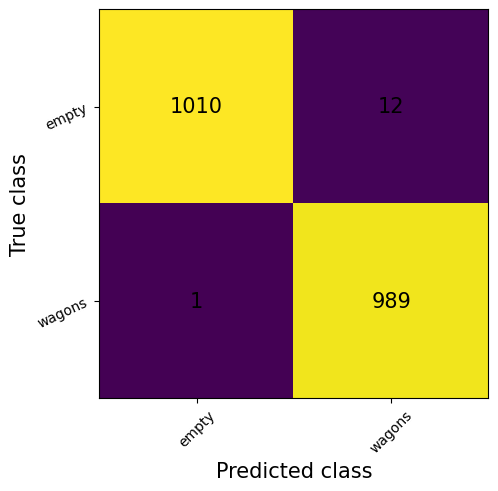

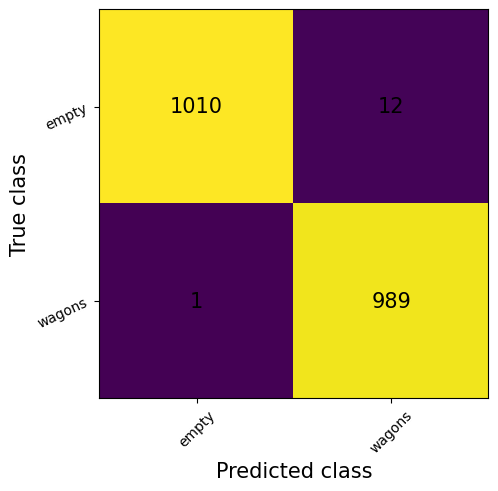

In [ ]:
confusion_matrix = ConfusionMatrix(task="binary", num_classes=2)
confusion_matrix.update(preds, targets)
fig, axes = confusion_matrix.plot()
axes.xaxis.set_ticklabels(["empty", "wagons"])
axes.yaxis.set_ticklabels(["empty", "wagons"])
fig